Dropping perfect-leak features: ['YEARS_OF_DONATING']


C:\Users\shyam\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\shyam\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:              made_gift   No. Observations:                 8062
Model:                          Logit   Df Residuals:                     8051
Method:                           MLE   Df Model:                           10
Date:                Tue, 27 May 2025   Pseudo R-squ.:                  0.3449
Time:                        23:27:41   Log-Likelihood:                -3394.0
converged:                      False   LL-Null:                       -5181.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0400      0.058    -17.817      0.000      -1.154      -0.926
TRANSFERS_2020_final    -0.0303      0.122     -0.248      0.804      -0.270       0.209
TRANSFERS_20

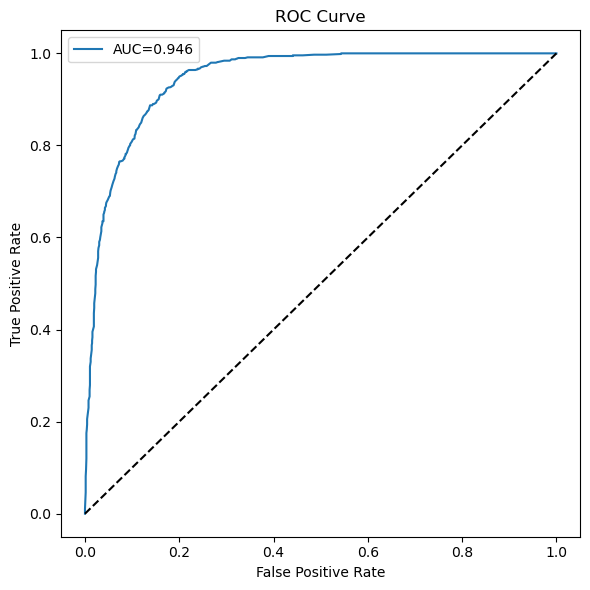


Top 10 RF Feature Importances:
            feature  importance
        eigenvector    0.225450
         F_TRANSFER    0.111949
         out_degree    0.081776
        betweenness    0.077141
WEBVISIT_2023_final    0.071377


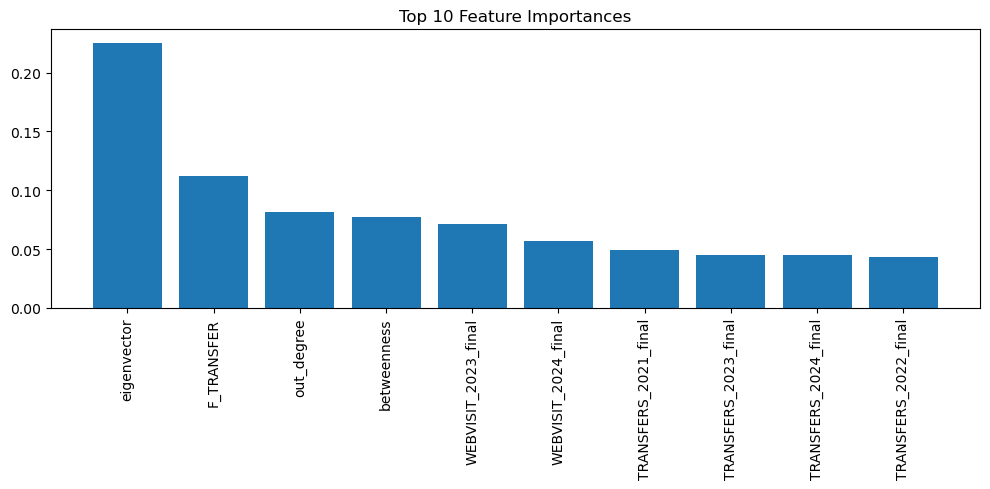


Top 10 Future Prospects:
                         account                   email  score
1aa133e8f9252f3bc70cf67978b53c86      pjrydeen@gmail.com  0.990
82ae68da591d17c6af7ae3631ef626d4   martiacarey@yahoo.com  0.985
d276b6cc36a96b1dca28f972e0c0cf98     mark.smrz@gmail.com  0.970
fbc9333ea5fc7f1b3bd9289ffb9f410d   nedrkline@comcast.net  0.965
2d9c018a4605c69b9194f83752dc4736  dale.j.tyler@gmail.com  0.935
c74d6caf95f467b843a2a12b95916a8e    dmobrien37@yahoo.com  0.930
9b02c0a9401ef1d2d7c1e1111ff7123c trgilbert2424@gmail.com  0.920
1cbff4ba068cc7fcd399081da7f908c4      mmcc1029@gmail.com  0.920
84f2bc213d00b7bd4e99ccda5ed637d7 baumgardner@charter.net  0.915
309cd0f6839088797e76074a1b3e68ba   migeorge@fastenal.com  0.915

—— Prospect Scoring Summary ——
Total non-donors scored: 6626
Non-donors with predicted score > 0: 4154
Non-donors with predicted score > 0.5: 120

========== Conventional Model (No Centrality Features) ==========
Dropping perfect-leak features (no centrality): ['YEARS_

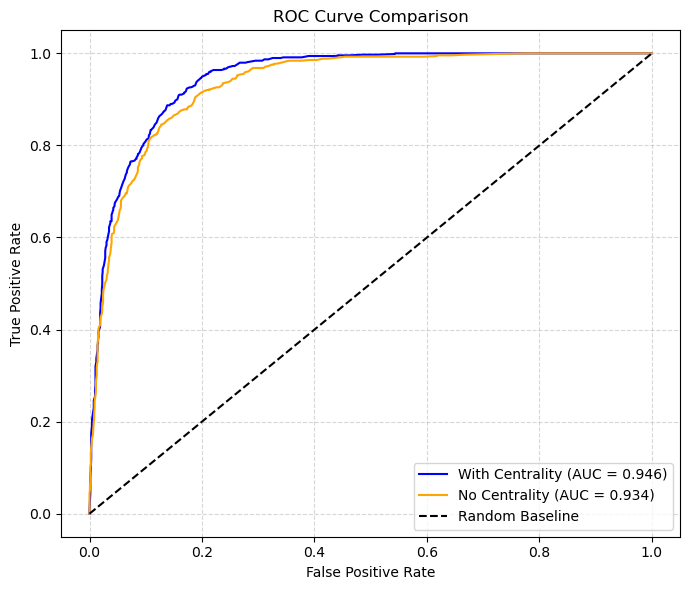

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# 1. Load dataset and define target
df = pd.read_csv('merged_dataset_WIS.csv')
df['made_gift'] = (df['MAX_LIFETIME_DONATION_AMOUNT'] > 0).astype(int)

# 2. Drop gift-related and metadata columns
drop_gift = [c for c in df.columns if 'greatest' in c.lower() or 'lifetime' in c.lower()]
drop_meta = [c for c in df.columns if any(k in c.lower() for k in ['key','id','name','email','date','status'])]
X = df.drop(columns=drop_gift + drop_meta + ['made_gift','TOTAL_CLICKTHROUGHS_final','TOTAL_TRANSFERS','community'])
y = df['made_gift']

# 3. Keep numeric features and fill NA
X = X.select_dtypes(include='number').fillna(0)

# 4. Remove perfect leakage columns
leakers = []
for col in X.columns:
    non_don_max = X.loc[y==0, col].max()
    don_min     = X.loc[y==1, col].min()
    don_max     = X.loc[y==1, col].max()
    non_don_min = X.loc[y==0, col].min()
    if non_don_max < don_min or don_max < non_don_min:
        leakers.append(col)

if leakers:
    print("Dropping perfect-leak features:", leakers)
    X = X.drop(columns=leakers)

# 5. Drop near-zero variance features
vt = VarianceThreshold(threshold=0.0)
vt.fit(X)
X = pd.DataFrame(vt.transform(X), columns=X.columns[vt.get_support()])

# 6. Drop perfectly correlated columns
corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
perfect_dups = [col for col in upper.columns if any(upper[col] == 1.0)]
if perfect_dups:
    print("Dropping perfectly correlated columns:", perfect_dups)
    X = X.drop(columns=perfect_dups)

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Feature selection using VIF
X2 = sm.add_constant(X_train)
vif_df = pd.DataFrame({
    "feature": X2.columns,
    "VIF": [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
})
to_drop = vif_df[vif_df["VIF"] > 10]["feature"].tolist()
X2_reduced = X2.drop(columns=to_drop)

# 9. Logistic regression for interpretability
logit = sm.Logit(y_train, X2_reduced).fit(disp=False)
print(logit.summary())

# 10. Cross-validation on training set
rf_cv = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
cv_scores = cross_val_score(rf_cv, X_train, y_train, cv=5, scoring='roc_auc')

print("\n—— Cross-Validation Performance ——")
print(f"AUC scores for each fold: {np.round(cv_scores, 3)}")
print(f"Mean CV AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 11. Train final model
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# 12. Evaluate on test set
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("\n—— Random Forest Classification Report ——")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)
print(f"Test ROC AUC: {auc:.3f}")

# 13. ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 14. Feature importances
imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 RF Feature Importances:")
print(imp_df.head(5).to_string(index=False))

plt.figure(figsize=(10,5))
plt.bar(imp_df['feature'][:10], imp_df['importance'][:10])
plt.xticks(rotation=90)
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# 15. Score non-donors
pros = X.loc[df['made_gift'] == 0].copy()
pros['score']   = rf.predict_proba(pros)[:,1]
pros['account'] = df.loc[pros.index,'SENDER_DIM_ACCOUNT_KEY']
pros['email']   = df.loc[pros.index,'PREFERRED_EMAIL']
pros['community']   = df.loc[pros.index,'community']

print("\nTop 10 Future Prospects:")
print(pros[['account','email','score']]
      .sort_values('score',ascending=False)
      .head(10)
      .to_string(index=False))

# 16. Summary statistics
total_records = len(pros)
non_donors = (df['made_gift'] == 0).sum()
non_zero_score = (pros['score'] > 0).sum()
above_0_5_score = (pros['score'] > 0.5).sum()

print("\n—— Prospect Scoring Summary ——")
print(f"Total non-donors scored: {total_records}")
print(f"Non-donors with predicted score > 0: {non_zero_score}")
print(f"Non-donors with predicted score > 0.5: {above_0_5_score}")

# --- CONVENTIONAL MODEL: Without Centrality Measures ---
print("\n========== Conventional Model (No Centrality Features) ==========")

# 1. Define centrality-related column names to exclude
centrality_cols = ['out_degree', 'degree_centrality', 'betweenness', 'eigenvector']

# 2. Rebuild X without centrality measures
X_no_centrality = df.drop(columns=drop_gift + drop_meta + ['made_gift','TOTAL_CLICKTHROUGHS_final','TOTAL_TRANSFERS','community'])
X_no_centrality = X_no_centrality.select_dtypes(include='number').drop(columns=[col for col in centrality_cols if col in df.columns], errors='ignore')
X_no_centrality = X_no_centrality.fillna(0)

# 3. Repeat leaker detection
leakers = []
for col in X_no_centrality.columns:
    non_don_max = X_no_centrality.loc[y==0, col].max()
    don_min     = X_no_centrality.loc[y==1, col].min()
    don_max     = X_no_centrality.loc[y==1, col].max()
    non_don_min = X_no_centrality.loc[y==0, col].min()
    if non_don_max < don_min or don_max < non_don_min:
        leakers.append(col)
if leakers:
    print("Dropping perfect-leak features (no centrality):", leakers)
    X_no_centrality = X_no_centrality.drop(columns=leakers)

# 4. Drop low variance and perfect correlations
vt_nc = VarianceThreshold(threshold=0.0)
vt_nc.fit(X_no_centrality)
X_no_centrality = pd.DataFrame(vt_nc.transform(X_no_centrality), columns=X_no_centrality.columns[vt_nc.get_support()])

corr_nc = X_no_centrality.corr().abs()
upper_nc = corr_nc.where(np.triu(np.ones(corr_nc.shape), k=1).astype(bool))
perfect_dups_nc = [col for col in upper_nc.columns if any(upper_nc[col] == 1.0)]
if perfect_dups_nc:
    print("Dropping perfectly correlated columns (no centrality):", perfect_dups_nc)
    X_no_centrality = X_no_centrality.drop(columns=perfect_dups_nc)

# 5. Train/test split
X_nc_train, X_nc_test, y_nc_train, y_nc_test = train_test_split(
    X_no_centrality, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Train RF model
rf_nc = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_nc.fit(X_nc_train, y_nc_train)

# 7. Predict & evaluate
y_nc_pred = rf_nc.predict(X_nc_test)
y_nc_prob = rf_nc.predict_proba(X_nc_test)[:, 1]

print("\n—— RF (No Centrality) Classification Report ——")
print(classification_report(y_nc_test, y_nc_pred))
auc_nc = roc_auc_score(y_nc_test, y_nc_prob)
print(f"Test ROC AUC (No Centrality): {auc_nc:.3f}")

# 8. Feature Importances
imp_nc_df = pd.DataFrame({
    'feature': X_no_centrality.columns,
    'importance': rf_nc.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 Feature Importances (No Centrality):")
print(imp_nc_df.head(10).to_string(index=False))


# ROC curves for both models
fpr_with, tpr_with, _ = roc_curve(y_test, y_prob)           # From full model
fpr_without, tpr_without, _ = roc_curve(y_nc_test, y_nc_prob)  # From no-centrality model

# Plotting both
plt.figure(figsize=(7, 6))
plt.plot(fpr_with, tpr_with, label=f"With Centrality (AUC = {auc:.3f})", color='blue')
plt.plot(fpr_without, tpr_without, label=f"No Centrality (AUC = {auc_nc:.3f})", color='orange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
